# Data Exploratory and Machine Learning Analysis

In [1]:
#Importing the necessary packages for this section of the porject
import numpy as np
import pandas as pd
import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!pip install geocoder
import geocoder

import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

Solving environment: done

# All requested packages already installed.



### Importing the Data

In [2]:
#First the compiled data is imported
df = pd.read_csv("compiled_data.csv")
df[:10]

,Unnamed: 0,Borough,Neighborhood,zip code,covid19 cases,Latitude,Longitude
0,0,Bronx,Bronx Park,"10458, 10467, 10468",27981,40.876653,-73.871508
1,1,Bronx,Central Bronx,"10453, 10457, 10460",20870,40.846411,-73.898446
2,2,Bronx,Fordham,"10458, 10467, 10468",27981,40.876653,-73.871508
3,3,Bronx,High Bridge,"10451, 10452, 10456",22884,40.837314,-73.922428
4,4,Bronx,Hunts Point,"10454, 10455, 10459, 10474",14367,40.813229,-73.905183
5,5,Bronx,Kingsbridge,"10463, 10471",12000,40.879335,-73.910328
6,6,Bronx,Morrisania,"10451, 10452, 10456",22884,40.837314,-73.922428
7,7,Bronx,Mott Haven,"10454, 10455, 10459, 10474",14367,40.813229,-73.905183
8,8,Bronx,Northeast Bronx,"10466, 10469, 10470, 10475",24984,40.869950,-73.844118
9,9,Bronx,Riverdale,"10463, 10471",12000,40.879335,-73.910328


In [3]:
#Some areas have overlapping coordinates and covid cases, these rows will be combined
combinedf1 = df.groupby(["Borough", "zip code", "Latitude", "Longitude", "covid19 cases"])["Neighborhood"].apply(" and ".join).to_frame().reset_index()
combinedf1[:10]

,Borough,zip code,Latitude,Longitude,covid19 cases,Neighborhood
0,Bronx,"10451, 10452, 10456",40.837314,-73.922428,22884,High Bridge and Morrisania
1,Bronx,"10453, 10457, 10460",40.846411,-73.898446,20870,Central Bronx
2,Bronx,"10454, 10455, 10459, 10474",40.813229,-73.905183,14367,Hunts Point and Mott Haven
3,Bronx,"10458, 10467, 10468",40.876653,-73.871508,27981,Bronx Park and Fordham
4,Bronx,"10461, 10462, 10464, 10465, 10472, 10473",40.862717,-73.793643,33947,Southeast Bronx
5,Bronx,"10463, 10471",40.879335,-73.910328,12000,Kingsbridge and Riverdale
6,Bronx,"10466, 10469, 10470, 10475",40.869950,-73.844118,24984,Northeast Bronx
7,Brooklyn,"11201, 11205, 11215, 11217, 11231",40.665090,-73.980306,19361,Northwest Brooklyn
8,Brooklyn,"11203, 11210, 11225, 11226",40.625556,-73.945896,26174,Flatbush
9,Brooklyn,"11204, 11218, 11219, 11230",40.644512,-73.978228,39261,Borough Park


### Exploratory Analysis

In [4]:
#Defining instance of the geocoder and user_agent
address = "New York, US"

geolocator = Nominatim(user_agent = "ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [5]:
#Creating a map of NYC using the latitude and longitude of the city and neighborhoods
#Neighborhoods in the same borough are shown in the same colored markers
map_nyc = folium.Map(location = [latitude, longitude], zoom_start = 10)
colordict = {"Bronx": "red", "Brooklyn": "blue", "Queens": "green", "Manhattan": "yellow", "Staten Island": "purple"}

for lat, lng, borough, neighborhood in zip(combinedf1["Latitude"], combinedf1["Longitude"], combinedf1["Borough"], combinedf1["Neighborhood"]):
    labeltext = borough + ": " + neighborhood
    label = folium.Popup(labeltext)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = colordict[borough],
        fill = True,
        fill_color = colordict[borough],
        fill_opacity = 1.0).add_to(map_nyc)

map_nyc

In [6]:
#Examining and comparing the number of covid cases in each neighborhood using bar charts
#Importing matplotlib.pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

<BarContainer object of 42 artists>

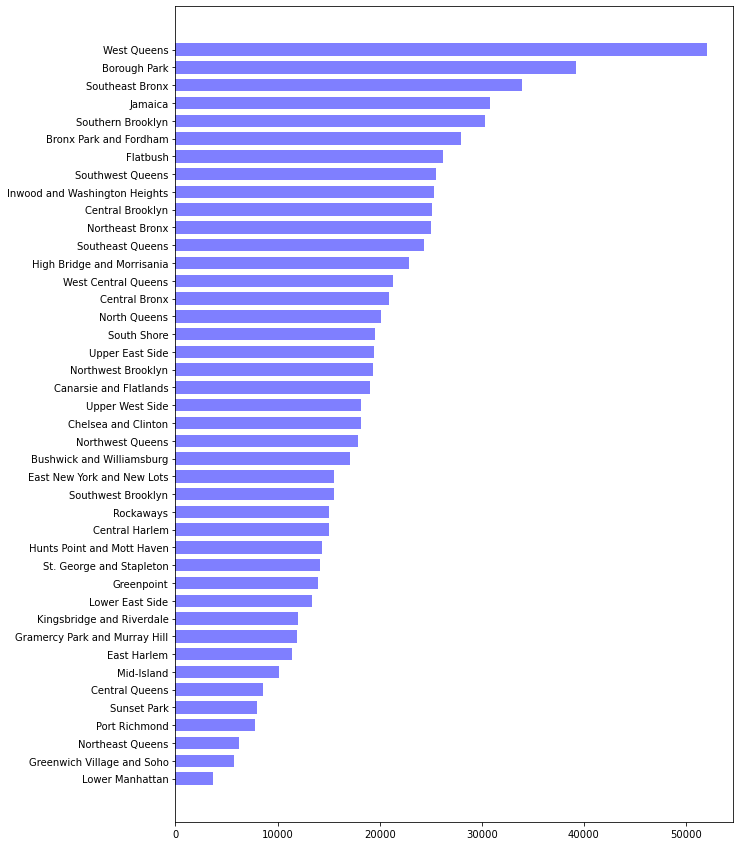

In [7]:
figure(figsize = (10, 15))
tempdf = combinedf1.sort_values("covid19 cases")
plt.barh(tempdf["Neighborhood"], tempdf["covid19 cases"], align = "center", alpha = 0.5, height = 0.7, color = "blue")

In [8]:
#Taking a look at the percentage of total covid cases of each borough
#Calculating the total covid cases of each borough
tempdf = combinedf1.groupby("Borough")["covid19 cases"].sum().to_frame()
tempdf

,covid19 cases
Borough,
Bronx,157033
Brooklyn,229312
Manhattan,142359
Queens,221947
Staten Island,51611


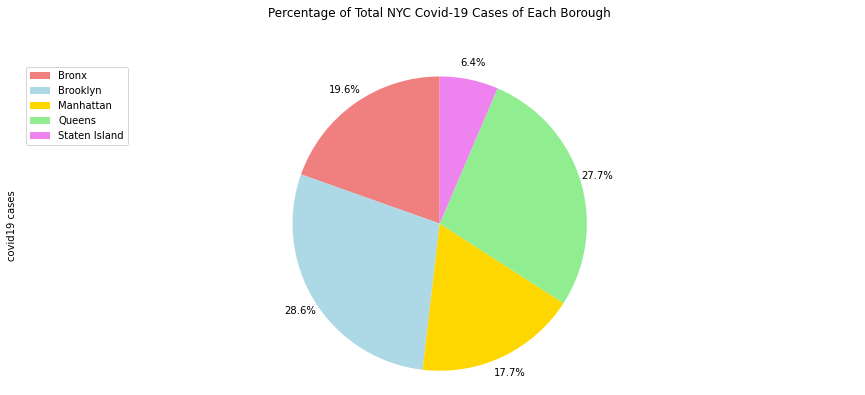

In [9]:
#Creating the pie chart
colors_list = ["lightcoral", "lightblue", "gold", "lightgreen", "violet"]
explode_list = [0.1, 0, 0, 0, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

tempdf["covid19 cases"].plot(kind = "pie",
                            figsize=(15, 6),
                            autopct='%1.1f%%',
                            startangle = 90,       
                            labels = None,
                            pctdistance=1.12, 
                            colors = colors_list,  # add custom colors
                            )

plt.title("Percentage of Total NYC Covid-19 Cases of Each Borough", y = 1.12) 
plt.axis("equal") 
plt.legend(labels = tempdf.index, loc = "upper left") 

plt.show()

After exploring the Covid-19 data, let's take a look at the various different venues in New York City. Specifically venues in the various neighborhoods.

In [10]:
#Defining foursquare API credentials
CLIENT_ID = "V4GWO2TSJQVWVACHL3Q2WNKIVNXXEZI4MIOE1VXIBSLD0RSC"
CLIENT_SECRET = "0ZONPIGVYRRIHWIBCUVFTWE5FG4VUNUDBXN22KT4RHYTVG55"
VERSION = "20180605"

In [11]:
#Function for getting nearby venues for each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v["venue"]["name"], 
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["categories"][0]["name"]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["Neighborhood", 
                  "Neighborhood Latitude", 
                  "Neighborhood Longitude", 
                  "Venue", 
                  "Venue Latitude", 
                  "Venue Longitude", 
                  "Venue Category"]
    
    print("Found {} venues in {} neighborhoods.".format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [12]:
nyc_venues = getNearbyVenues(names = combinedf1["Neighborhood"],
                                   latitudes = combinedf1["Latitude"],
                                   longitudes = combinedf1["Longitude"]
                                  )

Found 1829 venues in 42 neighborhoods.


In [13]:
#Examining the number of venues per neighborhood
nyc_venues.groupby("Neighborhood").count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Borough Park,50,50,50,50,50,50
Bronx Park and Fordham,21,21,21,21,21,21
Bushwick and Williamsburg,36,36,36,36,36,36
Canarsie and Flatlands,10,10,10,10,10,10
Central Bronx,22,22,22,22,22,22
Central Brooklyn,90,90,90,90,90,90
Central Harlem,68,68,68,68,68,68
Central Queens,37,37,37,37,37,37
Chelsea and Clinton,100,100,100,100,100,100


In [14]:
#Examining the number of unique venue categories in nyc
print("There are {} uniques categories.".format(len(nyc_venues["Venue Category"].unique())))

There are 277 uniques categories.


In [15]:
#Analyzing each neighborhood
#First converting the dataframe using the one hot encoding technique
nyc_onehot = pd.get_dummies(nyc_venues[["Venue Category"]], prefix = "", prefix_sep = "")
nyc_onehot["Neighborhood"] = nyc_venues["Neighborhood"] 

#Moving neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

#Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category
nyc_grouped = nyc_onehot.groupby("Neighborhood").mean().reset_index()
nyc_grouped[:10]

,Neighborhood,African Restaurant,American Restaurant,Animal Shelter,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Borough Park,0.000000,0.020000,0.02,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.02
1,Bronx Park and Fordham,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.047619,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00
2,Bushwick and Williamsburg,0.000000,0.027778,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00
3,Canarsie and Flatlands,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00
4,Central Bronx,0.000000,0.045455,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00
5,Central Brooklyn,0.000000,0.011111,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.011111,0.0,0.000000,0.0,0.0,0.011111,0.022222,0.0,0.00,0.00
6,Central Harlem,0.014706,0.029412,0.00,0.0,0.0,0.014706,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00
7,Central Queens,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.027027,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00
8,Chelsea and Clinton,0.000000,0.030000,0.00,0.0,0.0,0.070000,0.0,0.010000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.010000,0.000000,0.0,0.02,0.00
9,East Harlem,0.000000,0.027778,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.027778,0.0,0.0,0.000000,0.027778,0.0,0.00,0.00


In [16]:
#Sorting the venues and displaying the top 10 venues for each neighborhood
#Function for sorting the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
#Creating a new dataframe and displaying the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ["st", "nd", "rd"]

# create columns according to number of top venues
columns = ["Neighborhood"]
for ind in np.arange(num_top_venues):
    try:
        columns.append("{}{} Most Common Venue".format(ind + 1, indicators[ind]))
    except:
        columns.append("{}th Most Common Venue".format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted["Neighborhood"] = nyc_grouped["Neighborhood"]

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted[:10]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Borough Park,Pizza Place,Thai Restaurant,Café,Grocery Store,Mexican Restaurant,Deli / Bodega,Spa,Sandwich Place,Pet Store,Convenience Store
1,Bronx Park and Fordham,Supermarket,Park,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Brazilian Restaurant,Metro Station,Smoke Shop
2,Bushwick and Williamsburg,Pizza Place,Bar,Café,Coffee Shop,Spanish Restaurant,Deli / Bodega,Food Truck,Metro Station,Grocery Store,Music Venue
3,Canarsie and Flatlands,Caribbean Restaurant,Pizza Place,Diner,Taco Place,Bank,Fast Food Restaurant,Bagel Shop,Mobile Phone Shop,Flower Shop,Food
4,Central Bronx,Fast Food Restaurant,Donut Shop,Fried Chicken Joint,Pizza Place,Nightclub,Park,Bank,Sandwich Place,Gas Station,Martial Arts Dojo
5,Central Brooklyn,Caribbean Restaurant,Coffee Shop,Bar,Café,Pizza Place,Seafood Restaurant,Grocery Store,Music Venue,Juice Bar,Thrift / Vintage Store
6,Central Harlem,Deli / Bodega,Southern / Soul Food Restaurant,Ice Cream Shop,Bar,Fried Chicken Joint,Sandwich Place,Chinese Restaurant,Lounge,Burger Joint,Pizza Place
7,Central Queens,Restaurant,Japanese Restaurant,Sandwich Place,Chinese Restaurant,Optical Shop,Grocery Store,Market,Martial Arts Dojo,Mattress Store,Shipping Store
8,Chelsea and Clinton,Coffee Shop,Art Gallery,Hotel,Bakery,American Restaurant,Italian Restaurant,French Restaurant,Seafood Restaurant,Ice Cream Shop,Women's Store
9,East Harlem,Pizza Place,Supermarket,Clothing Store,Café,Trail,Food Truck,Gas Station,Shopping Mall,Mexican Restaurant,Park


### Clustering the Neighborhoods

In [18]:
#Prior to clustering, the dataframe containing binary venues information is merged with the covid-19 case-containing dataframe
combinedf2 = combinedf1.merge(nyc_grouped, on = "Neighborhood")
combinedf2[:10]

,Borough,zip code,Latitude,Longitude,covid19 cases,Neighborhood,African Restaurant,American Restaurant,Animal Shelter,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bronx,"10451, 10452, 10456",40.837314,-73.922428,22884,High Bridge and Morrisania,0.0,0.000000,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
1,Bronx,"10453, 10457, 10460",40.846411,-73.898446,20870,Central Bronx,0.0,0.045455,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
2,Bronx,"10454, 10455, 10459, 10474",40.813229,-73.905183,14367,Hunts Point and Mott Haven,0.0,0.000000,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
3,Bronx,"10458, 10467, 10468",40.876653,-73.871508,27981,Bronx Park and Fordham,0.0,0.000000,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
4,Bronx,"10461, 10462, 10464, 10465, 10472, 10473",40.862717,-73.793643,33947,Southeast Bronx,0.0,0.000000,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
5,Bronx,"10463, 10471",40.879335,-73.910328,12000,Kingsbridge and Riverdale,0.0,0.035714,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.035714
6,Bronx,"10466, 10469, 10470, 10475",40.869950,-73.844118,24984,Northeast Bronx,0.0,0.000000,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
7,Brooklyn,"11201, 11205, 11215, 11217, 11231",40.665090,-73.980306,19361,Northwest Brooklyn,0.0,0.020000,0.00,0.0,...,0.01,0.03,0.0,0.0,0.0,0.01,0.03,0.0,0.01,0.000000
8,Brooklyn,"11203, 11210, 11225, 11226",40.625556,-73.945896,26174,Flatbush,0.0,0.000000,0.00,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.000000
9,Brooklyn,"11204, 11218, 11219, 11230",40.644512,-73.978228,39261,Borough Park,0.0,0.020000,0.02,0.0,...,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.020000


In [19]:
#Determining the optimal number of clusters for the dataset
#Importing the required library
from sklearn.cluster import KMeans

In [20]:
#Creating a new dataframe with only the information we need to generate KMeans label
optimizing_df = combinedf2.drop(["Borough", "zip code", "Latitude", "Longitude", "Neighborhood"], axis = 1)

#Using the elbow method to find the best number of clusters for KMeans analysis
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(optimizing_df)
    Sum_of_squared_distances.append(km.inertia_)

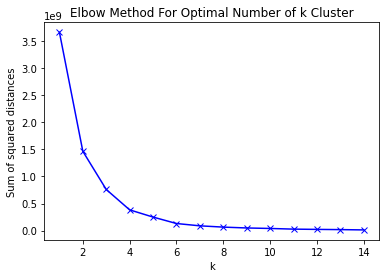

In [21]:
#Plotting the results of the calculations
plt.plot(K, Sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method For Optimal Number of k Cluster")
plt.show()

The elbow is at k = 4 and thus the analysis will proceed using a cluster number of 4.

In [22]:
#Clustering neighborhoods using KMeans using a cluster number of 4
kclusters = 4
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(optimizing_df)

#Checking the cluster labels generated
kmeans.labels_[0:10]

array([0, 3, 3, 0, 0, 1, 0, 3, 0, 2], dtype=int32)

In [23]:
#Creating dataframe that contains the clustering labels, top 10 venues, geographical information, and number of covid-19 cases
combinedf3 = combinedf1.merge(neighborhoods_venues_sorted, on = "Neighborhood")
combinedf3["Cluster Labels"] = kmeans.labels_
combinedf3[:10]

,Borough,zip code,Latitude,Longitude,covid19 cases,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Bronx,"10451, 10452, 10456",40.837314,-73.922428,22884,High Bridge and Morrisania,Pizza Place,Market,Seafood Restaurant,Nightclub,Fried Chicken Joint,Chinese Restaurant,Grocery Store,Gym,Pharmacy,Fast Food Restaurant,0
1,Bronx,"10453, 10457, 10460",40.846411,-73.898446,20870,Central Bronx,Fast Food Restaurant,Donut Shop,Fried Chicken Joint,Pizza Place,Nightclub,Park,Bank,Sandwich Place,Gas Station,Martial Arts Dojo,3
2,Bronx,"10454, 10455, 10459, 10474",40.813229,-73.905183,14367,Hunts Point and Mott Haven,Chinese Restaurant,Deli / Bodega,Bakery,Discount Store,Food Truck,Sandwich Place,Mexican Restaurant,Pizza Place,Donut Shop,Bus Station,3
3,Bronx,"10458, 10467, 10468",40.876653,-73.871508,27981,Bronx Park and Fordham,Supermarket,Park,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Brazilian Restaurant,Metro Station,Smoke Shop,0
4,Bronx,"10461, 10462, 10464, 10465, 10472, 10473",40.862717,-73.793643,33947,Southeast Bronx,Bus Station,Food Court,Yoga Studio,Food Truck,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,French Restaurant,0
5,Bronx,"10463, 10471",40.879335,-73.910328,12000,Kingsbridge and Riverdale,Donut Shop,Sandwich Place,Pizza Place,Gym,Yoga Studio,Candy Store,Tennis Stadium,Mexican Restaurant,Discount Store,Steakhouse,1
6,Bronx,"10466, 10469, 10470, 10475",40.869950,-73.844118,24984,Northeast Bronx,Caribbean Restaurant,Deli / Bodega,Food & Drink Shop,Bank,Nail Salon,Donut Shop,Fried Chicken Joint,Pharmacy,Pizza Place,Spa,0
7,Brooklyn,"11201, 11205, 11215, 11217, 11231",40.665090,-73.980306,19361,Northwest Brooklyn,Café,Italian Restaurant,Coffee Shop,Park,Pizza Place,Bakery,Diner,Bar,Thai Restaurant,Mexican Restaurant,3
8,Brooklyn,"11203, 11210, 11225, 11226",40.625556,-73.945896,26174,Flatbush,Caribbean Restaurant,Sushi Restaurant,Ice Cream Shop,Discount Store,Breakfast Spot,Café,Clothing Store,Pharmacy,Toy / Game Store,Supermarket,0
9,Brooklyn,"11204, 11218, 11219, 11230",40.644512,-73.978228,39261,Borough Park,Pizza Place,Thai Restaurant,Café,Grocery Store,Mexican Restaurant,Deli / Bodega,Spa,Sandwich Place,Pet Store,Convenience Store,2


In [24]:
#Mapping the clusters on the nyc map
#Creating map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Adding markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(combinedf3["Latitude"], combinedf3["Longitude"], combinedf3["Neighborhood"], combinedf3["Cluster Labels"]):
    label = folium.Popup(str(poi) + " Cluster " + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = "gray",
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 1.0).add_to(map_clusters)
       
map_clusters

In [25]:
#Creating dataframes for individual clusters
nyclowrisk = combinedf3.loc[combinedf3['Cluster Labels'] == 1].drop(["zip code", "Latitude", "Longitude"], axis = 1).set_index("Cluster Labels")
nycmedrisk = combinedf3.loc[combinedf3['Cluster Labels'] == 3].drop(["zip code", "Latitude", "Longitude"], axis = 1).set_index("Cluster Labels")
nychighrisk = combinedf3.loc[combinedf3['Cluster Labels'] == 0].drop(["zip code", "Latitude", "Longitude"], axis = 1).set_index("Cluster Labels")
nycvhighrisk = combinedf3.loc[combinedf3['Cluster Labels'] == 2].drop(["zip code", "Latitude", "Longitude"], axis = 1).set_index("Cluster Labels")

In [26]:
#Examining the dataframe for each cluster
nyclowrisk.head()

,Borough,covid19 cases,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
1,Bronx,12000,Kingsbridge and Riverdale,Donut Shop,Sandwich Place,Pizza Place,Gym,Yoga Studio,Candy Store,Tennis Stadium,Mexican Restaurant,Discount Store,Steakhouse
1,Brooklyn,7947,Sunset Park,Furniture / Home Store,Bar,Bakery,Coffee Shop,Gas Station,Hotel,Food Court,Restaurant,Brewery,Café
1,Manhattan,3710,Lower Manhattan,Coffee Shop,Pizza Place,Hotel,Park,Memorial Site,Gym / Fitness Center,Gourmet Shop,Plaza,Falafel Restaurant,Monument / Landmark
1,Manhattan,11931,Gramercy Park and Murray Hill,Bar,Indian Restaurant,Sushi Restaurant,Gym / Fitness Center,Pizza Place,Ice Cream Shop,Mediterranean Restaurant,Gym,Coffee Shop,Spa
1,Manhattan,5780,Greenwich Village and Soho,Cocktail Bar,Spa,American Restaurant,Park,Hotel,Men's Store,Coffee Shop,Greek Restaurant,Gym / Fitness Center,French Restaurant


In [27]:
nycmedrisk.head()

,Borough,covid19 cases,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
3,Bronx,20870,Central Bronx,Fast Food Restaurant,Donut Shop,Fried Chicken Joint,Pizza Place,Nightclub,Park,Bank,Sandwich Place,Gas Station,Martial Arts Dojo
3,Bronx,14367,Hunts Point and Mott Haven,Chinese Restaurant,Deli / Bodega,Bakery,Discount Store,Food Truck,Sandwich Place,Mexican Restaurant,Pizza Place,Donut Shop,Bus Station
3,Brooklyn,19361,Northwest Brooklyn,Café,Italian Restaurant,Coffee Shop,Park,Pizza Place,Bakery,Diner,Bar,Thai Restaurant,Mexican Restaurant
3,Brooklyn,17095,Bushwick and Williamsburg,Pizza Place,Bar,Café,Coffee Shop,Spanish Restaurant,Deli / Bodega,Food Truck,Metro Station,Grocery Store,Music Venue
3,Brooklyn,15547,East New York and New Lots,Pizza Place,Sandwich Place,Metro Station,Chinese Restaurant,Supermarket,Discount Store,Deli / Bodega,Spanish Restaurant,Grocery Store,Pharmacy


In [28]:
nychighrisk.head()

,Borough,covid19 cases,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
0,Bronx,22884,High Bridge and Morrisania,Pizza Place,Market,Seafood Restaurant,Nightclub,Fried Chicken Joint,Chinese Restaurant,Grocery Store,Gym,Pharmacy,Fast Food Restaurant
0,Bronx,27981,Bronx Park and Fordham,Supermarket,Park,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Brazilian Restaurant,Metro Station,Smoke Shop
0,Bronx,33947,Southeast Bronx,Bus Station,Food Court,Yoga Studio,Food Truck,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,French Restaurant
0,Bronx,24984,Northeast Bronx,Caribbean Restaurant,Deli / Bodega,Food & Drink Shop,Bank,Nail Salon,Donut Shop,Fried Chicken Joint,Pharmacy,Pizza Place,Spa
0,Brooklyn,26174,Flatbush,Caribbean Restaurant,Sushi Restaurant,Ice Cream Shop,Discount Store,Breakfast Spot,Café,Clothing Store,Pharmacy,Toy / Game Store,Supermarket


In [29]:
nycvhighrisk.head()

,Borough,covid19 cases,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,
2,Brooklyn,39261,Borough Park,Pizza Place,Thai Restaurant,Café,Grocery Store,Mexican Restaurant,Deli / Bodega,Spa,Sandwich Place,Pet Store,Convenience Store
2,Queens,52031,West Queens,Latin American Restaurant,South American Restaurant,Peruvian Restaurant,Mexican Restaurant,Bakery,Thai Restaurant,Pizza Place,Mobile Phone Shop,Grocery Store,Kids Store
